# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

## <span style='color:deepskyblue'>Preliminaries</span>

In [2]:
# Install required packages (if not available on server)
%pip install getdist
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [3]:
PARSEC = 3.086e16 # in meters
H0=70 # in kg/s/Mpc

# Hubble rate
def Hubble(z, H0, omega_m, omega_l): 
    omega_k=1-(omega_m+omega_l) # curvature density fraction
    return H0*((omega_l+omega_m*(1+z)**3+omega_k*(1+z)**2)**0.5)
print(f"Hubble rate for when z=0.2: {Hubble(0.2,H0,0.3,0.7)} km/s/Mpc")

Hubble rate for when z=0.2: 77.26681046866112 km/s/Mpc


##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [5]:
import numpy as np
import scipy.integrate as spi

SPEED_OF_LIGHT = 2.99e5 # speed of light in km/s
MPC_TO_PARSEC=1e6 # conversion factor from Mpc to parsec

def Hubble(z, H0, omega_m, omega_l): # hubble rate from previous step
    omega_k = 1 - (omega_m + omega_l)
    return H0 * np.sqrt(omega_m * (1 + z) ** 3 + omega_k * (1 + z) ** 2 + omega_l)

def D_integrand(z,Hubble,H0,omega_m,omega_l): 
    # computes the integrant 1/H(z) for the comoving distance calculation
    return 1/Hubble(z,H0,omega_m,omega_l) # returns inverse of the hubble parameter at redshift z
    
def D(z,Hubble,H0,omega_m,omega_l): 
    # function computing comoving distance D(z) by integrating 1/H(z) from 0 to z
    integral,_=spi.quad(D_integrand,0,z,args=(Hubble,H0,omega_m,omega_l))
    return H0*integral 
    
def dL(z,Hubble,H0,omega_m,omega_l): 
    # function to compute the lumonisty distance in parsecs
    omega_k=1-(omega_m+omega_l)
    Dz=D(z,Hubble,H0,omega_m,omega_l) # compute comoving distance
    
    # computes based on the curvature of the universe
    if omega_k>0: # open universe (positive)
        distance=(SPEED_OF_LIGHT/H0)*(1+z)*(np.sinh(np.sqrt(omega_k)*Dz)/np.sqrt(omega_k))
    elif omega_k==0: # flat universe
        distance=(SPEED_OF_LIGHT/H0)*(1+z)*Dz
    else: # if omega_k<0, closed universe (negative)
        distance=(SPEED_OF_LIGHT/H0)*(1+z)*(np.sin(np.sqrt(-omega_k)*Dz)/np.sqrt(-omega_k))
    return distance*MPC_TO_PARSEC # convert from Mpc to parsecs

# test to see if function works
H0=70
omega_m=0.3
omega_l=0.7
z_test=0.2
print(f"Luminosity distance dL({z_test}) = {dL(z_test, Hubble, H0, omega_m, omega_l):.2f} parsecs")

Luminosity distance dL(0.2) = 977477219.17 parsecs


## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [7]:
file_path="./data.txt"
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt("./data.txt")

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [8]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1]  # redshifts
dist_mod = data.T[2]  # observed distance modulus
err_dist_mod = data.T[3]  # errors on the distance modulus

In [9]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

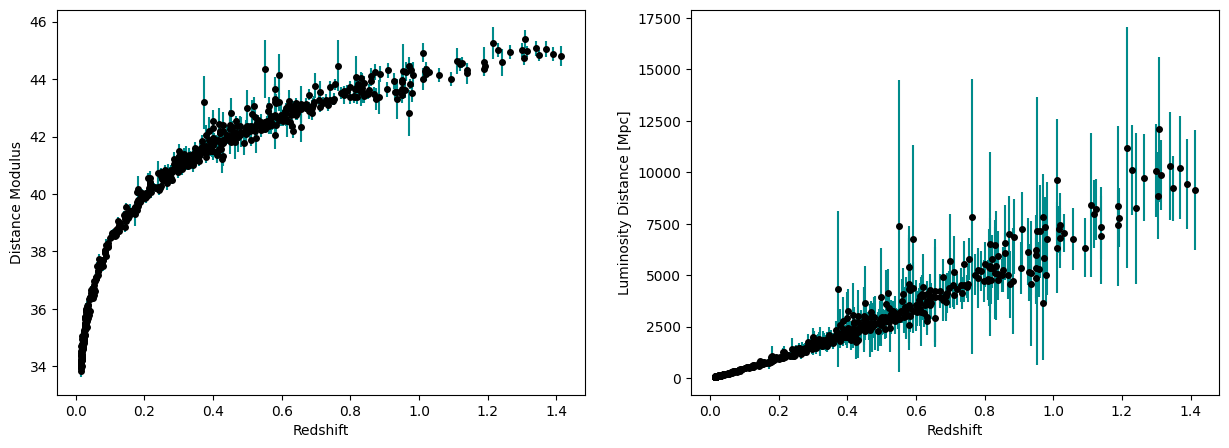

In [10]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [11]:
def chi_squared(params, zs, obs_mu, obs_mu_err):
# compute chi-squared from data set
# chi-squared: quantifies difference between theoretical predictions of cosmological model and
# observed supernova data. a lower chi-squared means better fit of model to data.

    h, omega_m, omega_l = params # define parameters
    H0_val = h * 100  # convert h to H0 in km/s/Mpc
    chi2 = 0.0
    # chi2: total chi-squared valye calculated by summing squared deviations bew model and data
    # each value is normalized by variance of observation

    for z, mu_obs, sigma in zip(zs, obs_mu, obs_mu_err):
        # compute dL and mu for each supernova data point
        dL_val = dL(z, Hubble, H0_val, omega_m, omega_l)
        # theoretical distance modulus
        mu_th = 5 * np.log10(dL_val / 10.0)
        # add squared diff between theoretical and observed values to total chi-squared (taken from ChatGPT)
        chi2 += ((mu_th - mu_obs) ** 2) / (sigma ** 2)
    return chi2
    

def prior(params):
    # prior: shows initial belief about parameter ranges before looking at data
    # returns 1 if parameters are within ranges, returns 0 if not (taken from ChatGPT)
    h, omega_m, omega_l = params
    if 0.5 < h < 0.9 and 0.0 < omega_m < 1.0 and 0.0 < omega_l < 1.5:
        return 1.0
    return 0.0

def posterior(params, zs, obs_mu, obs_mu_err):
    # computes chi-squared value and calculates likelihood assuming Gaussian error modelL ∝ exp(–χ²/2). (ChatGPT)
    # posterior: proportional to product of likelihood and prior, shows how well a set of params explains data
    pr = prior(params)
    if pr == 0: # checks prior probability first --> if prior = 0, then posterior = 0
        return 0.0
    chi2 = chi_squared(params, zs, obs_mu, obs_mu_err)
    return np.exp(-0.5 * chi2) * pr # returns unnormalized posterior probability (product of likelihood and prior)


# ---------
# MCMC function
# ---------


def run_mcmc(num_steps, initial_params, step_scales, zs, obs_mu, obs_mu_err):
    # executes the MCMC algorithm 

    chain = np.zeros((num_steps, len(initial_params))) # creates array to store parameter samples
    current_params = np.array(initial_params) # sets starting params for MCMC
    current_post = posterior(current_params, zs, obs_mu, obs_mu_err) # calculates posterior prob for initial param
    
    for i in range(num_steps):
        # propose new parameters by a Gaussian jump
        # each step proposes a new set of params by adding a small Gaussian-distributed ranodm value
        # (with standard deviations given by step_scales) to current params (taken from ChatGPT)
        proposal = current_params + np.random.normal(scale=step_scales, size=len(current_params))
        # automatically reject proposals that fall outside the prior (outside of range)
        if prior(proposal) == 0:
            chain[i] = current_params
            continue
        
        proposal_post = posterior(proposal, zs, obs_mu, obs_mu_err) # compute proposal's posterior
        acceptance_prob = proposal_post / current_post if current_post > 0 else 1.0 # computes acceptance probability as ratio
        # of proposed posterior to current posterior --> if current posterior == 0, then code sets acceptance prob to 1 to avoid div by 0 (taken from ChatGPT)
        
        # accept the proposal if it improves the posterior or with probability acceptance_prob
        if acceptance_prob >= 1 or np.random.rand() < acceptance_prob:
            # if proposed param give higher posterior prob, then proposal is accepted
            # if not, proposal is accepted with prob equal to acceptance_prob (using random number from uniform distrib btw 0 and 1) (taken from ChatGPT)
            current_params = proposal
            current_post = proposal_post
        
        chain[i] = current_params # stores current state in chain
    
    return chain


# ---------
# Run the MCMC and print the chain
# ---------

# initial parameters [h, omega_m, omega_l]
initial_params = [0.7, 0.3, 0.7]
# proposal step scales (taken from ChatGPT)
# step scales:  control magnitude of random steps, affecting efficiency of sampling
step_scales = [0.01, 0.01, 0.01]
num_steps = 3000  # total number of steps in the chain

chain = run_mcmc(num_steps, initial_params, step_scales, zs, dist_mod, err_dist_mod)


# print chain
print("\nOmega_m   Omega_L    h") # header
for params in chain:
    h_val = params[0] * 100  
    om_val = params[1]
    ol_val = params[2]
    print(f"{om_val:7.3f}   {ol_val:7.3f}   {h_val:7.1f}")

KeyboardInterrupt: 

After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

This code block uses the Metropolis-Hastings MCMC algorithm to estimate parameters in order to predict the distance modulus of supernovae. It first computes the chi-squared (discrepancy between predicted and observed data), then runs two functions to set a prior (ranges for paramteres) and calculate the posterior (how likley parameters are given the data). Next, the MCMC sampling function is executed to generate a chain of parameter samples that represent the posterior distribution. The final lines of the block print the final chain, displayinf the sampled parameters.

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

In [1]:
import getdist, IPython
from getdist import plots, MCSamples, loadMCSamples
#print('Version: ',getdist.__version__)
import numpy as np
import pylab
from random import random
from random import gauss
# If you want to use LaTeX in the labels. Not mandatory, but it looks nice ;)
pylab.rc('text',usetex=False) 

# reorder and scale columns so that samples appear as omega_m, omega_l, and h
# use np.column_stack to combine columns into 2D array (ChatGPT)
samples_getdist = np.column_stack((
    chain[:, 1],           # Omega_m (second column)
    chain[:, 2],           # Omega_l (third column)
    chain[:, 0] * 100    # h (first column) converted to km/s/Mpc
))

# creates list with internal identifiers for each param, used by GetDist
my_labels = [r'\Omega_m', r'\Omega_l', r'h']
# creates list with labels for each param to show up on plots
my_names = ['om', 'ol', 'h']

# creates MCSamples object using samples, names, and labels
# converts raw numpy array into format that GetDist understands
samples_obj = MCSamples(samples=samples_getdist, names=my_names, labels=my_labels)

# triangle (corner) plot
# shows 1D histograms on the diagonal, 2D contour plots off the diagonoal
plotter = plots.getSubplotPlotter(subplot_size=3) #getSubplotPlotter creates a plotter object and determines size (ChatGPT)
plotter.settings.axes_labelsize = 22 # label size
plotter.settings.axes_fontsize = 16 # font size
plotter.triangle_plot(samples_obj, filled=True) # uses plotter to create triangle plot
# filled=True fills in contours btw param plots (ChatGPT)
pylab.show()

NameError: name 'chain' is not defined

This block of code takes the output from the previous MCMC simulation, rearranges and scales it, and then uses GetDist to generate a triangle plot. The triangle plot shows 1D histograms along the diagonal for each parameter and 2D contour plots off the diagonal to represent the correlations between the parameters. 
The contour plots reveal that the Omega M and the Omega Lambda parameters were the most correlated (more elongated shape), while the Omega M and the h parameters were the least corrleated (more spherical shape). 



sources: https://espei.org/how-to/recipes/mcmc-corner-plots/, https://www.reddit.com/r/AskStatistics/comments/vr0fyj/mcmc_corner_plot_interpretation/


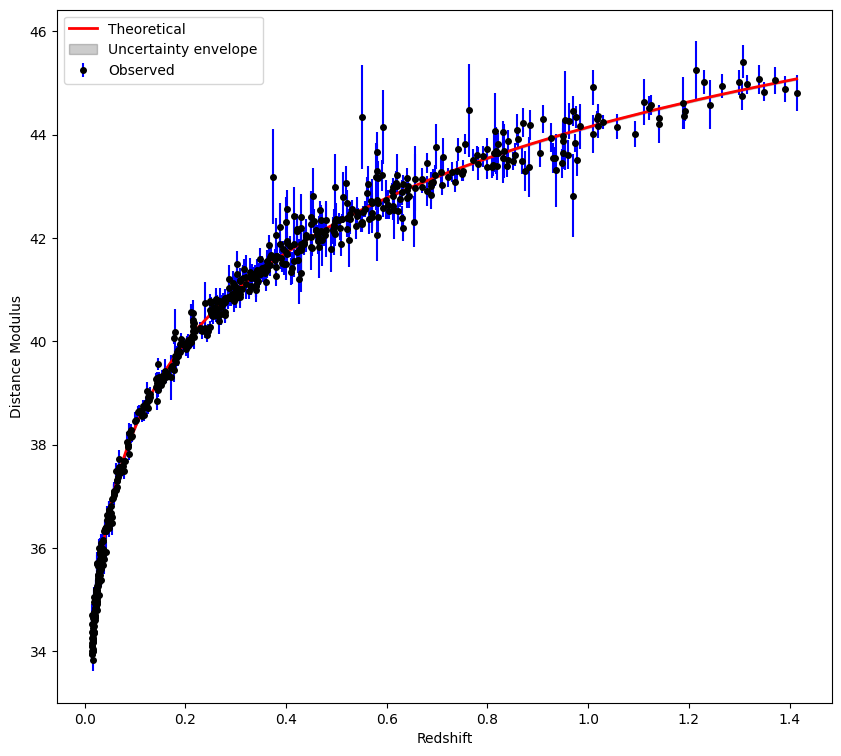

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    # computes theoretical dL in parsecs
    OmegaK=1-(OmegaM+OmegaL) # add OmegaK as curvature param
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaK * (1.+x)**2 + OmegaL), 0., z)[0]
    # added OmegaK to integrand to account for curvature in universe

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    # computes theoretical μ(z) from dL
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))


# ---------
# find best-fit params from my MCMC chain (method taken from ChatGPT)
# ---------

# compute best-fit or mean values 
best_h=np.mean(chain[:,0])*100 
best_omega_m=np.mean(chain[:,1])
best_omega_l=np.mean(chain[:,2])

# compute standard deviations
std_h=np.std(chain[:,0])*100
std_omega_m=np.std(chain[:,1])
std_omega_l=np.std(chain[:,2])

# ---------
# generate theoretical curves using best-fit values
# ---------

zsort = sorted(zs) # sorts redshift array for smooth plotting of theoretical curves
d_best_fit, d_min, d_max = [], [], [] # creates empty lists to store best fit and min/max values


for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, best_h, best_omega_m, best_omega_l))
    # add and subtract one std to each param for max and min (method from ChatGPT)
    d_min.append(theor_distance_modulus(z, best_h+std_h, best_omega_m+std_omega_m, best_omega_l+std_omega_l))
    d_max.append(theor_distance_modulus(z, best_h-std_h, best_omega_m-std_omega_m, best_omega_l-std_omega_l))

# ---------
# plot observed data and theoretical curves
# ---------    
plt.subplots(figsize=(10, 9))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='blue', markersize=4, label="Observed")
plt.plot(zsort, d_best_fit, color='red',linewidth=2, label='Theoretical')
plt.fill_between(zsort, d_min, d_max, color='black', alpha=.2, label='Uncertainty envelope')
plt.legend()
plt.show()

This code block begins by calculating the lumonisty distance and distance modulus. It then finds the best-fit values and uncertainties from the MCMC chain and generates a best-fit curve and an uncertainty envelope (+/- standard deviation) for the distance modulus as a function of redshift. It then plots these predictions along with the observed supernova data. Overall, the theoretical data seems to match relatively well with the observed data until about 0.6 redshift. After then, there are less observed data points, but they also appear to lay further from the trend of the predicted data.